In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Load the YOLO model
model = YOLO('yolo11n.pt')

# Function to download and display image
def load_image(source):
    if source.startswith('http'):
        response = requests.get(source)
        img = Image.open(BytesIO(response.content))
        return np.array(img)
    else:
        return cv2.imread(source)
        
# Load the test image
image_url = 'https://ultralytics.com/images/bus.jpg'
image = load_image(image_url)

print("Image loaded successfully!")
print(f"Image shape: {image.shape}")

# Run prediction to see what objects are detected
results = model.predict(source=image_url, verbose=False)
print(f"\nObjects detected in the image:")

# Get class names
class_names = model.names

# Print detected objects
for result in results:
    for box in result.boxes:
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        class_name = class_names[class_id]
        print(f"- {class_name}: {confidence:.2f}")

Image loaded successfully!
Image shape: (1080, 810, 3)
Found https://ultralytics.com/images/bus.jpg locally at bus.jpg

Objects detected in the image:
- bus: 0.94
- person: 0.89
- person: 0.88
- person: 0.86
- person: 0.62


In [2]:
def find_and_draw_object(image_source, target_object, confidence_threshold=0.5):
    """
    Find a specific object in an image and draw bounding boxes around it
    
    Args:
        image_source: URL or path to image
        target_object: Name of object to find (e.g., 'person', 'car', 'bus')
        confidence_threshold: Minimum confidence score to consider a detection
    
    Returns:
        Boolean indicating if object was found, and the image with bounding boxes
    """
    
    # Load image
    if image_source.startswith('http'):
        response = requests.get(image_source)
        img_pil = Image.open(BytesIO(response.content))
        img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    else:
        img_cv = cv2.imread(image_source)
        img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    
    # Run YOLO prediction
    results = model.predict(source=image_source, verbose=False)
    
    # Get class names
    class_names = model.names
    
    # Create a copy of the image for drawing
    img_with_boxes = img_cv.copy()
    
    object_found = False
    detections = []
    
    # Process results
    for result in results:
        boxes = result.boxes
        if boxes is not None:
            for box in boxes:
                # Get detection info
                class_id = int(box.cls[0])
                confidence = float(box.conf[0])
                class_name = class_names[class_id]
                
                # Check if this is the target object and meets confidence threshold
                if target_object.lower() in class_name.lower() and confidence >= confidence_threshold:
                    object_found = True
                    
                    # Get bounding box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    
                    # Draw bounding box
                    cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 3)
                    
                    # Draw label
                    label = f"{class_name}: {confidence:.2f}"
                    label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
                    cv2.rectangle(img_with_boxes, (x1, y1 - label_size[1] - 10), 
                                (x1 + label_size[0], y1), (0, 255, 0), -1)
                    cv2.putText(img_with_boxes, label, (x1, y1 - 5), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
                    
                    detections.append({
                        'class': class_name,
                        'confidence': confidence,
                        'bbox': [x1, y1, x2, y2]
                    })
    
    # Convert BGR to RGB for matplotlib display
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    
    return object_found, img_rgb, detections

In [6]:
# Interactive function to ask about objects in the image
def ask_yolo(question, image_source, confidence_threshold=0.5):
    """
    Ask YOLO if a specific object exists in an image
    
    Args:
        question: Question like "Is there a bus in the image?" or "Do you see any people?"
        image_source: URL or path to image
        confidence_threshold: Minimum confidence to consider detection valid
    """
    
    # Extract object name from question (simple keyword matching)
    question_lower = question.lower()
    
    # Common object mappings
    object_keywords = {
        'person': ['person', 'people', 'human', 'man', 'woman'],
        'car': ['car', 'automobile', 'vehicle'],
        'bus': ['bus'],
        'truck': ['truck'],
        'bicycle': ['bicycle', 'bike'],
        'motorcycle': ['motorcycle', 'motorbike'],
        'dog': ['dog', 'puppy'],
        'cat': ['cat', 'kitten'],
        'bird': ['bird'],
        'horse': ['horse'],
        'sheep': ['sheep'],
        'cow': ['cow'],
        'elephant': ['elephant'],
        'bear': ['bear'],
        'zebra': ['zebra'],
        'giraffe': ['giraffe'],
        'deer': ['deer']
    }
    
    # Find matching object
    target_object = None
    for obj, keywords in object_keywords.items():
        if any(keyword in question_lower for keyword in keywords):
            target_object = obj
            break
    
    if target_object is None:
        print("I couldn't understand what object you're looking for.")
        print("Try asking about: person, car, bus, truck, bicycle, dog, cat, bird, etc.")
        return None, None, []
    
    print(f"Looking for: {target_object}")
    
    # Search for the object
    found, img_with_boxes, detections = find_and_draw_object(image_source, target_object, confidence_threshold)
    
    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(img_with_boxes)
    plt.axis('off')
    
    if found:
        plt.title(f"✅ Yes! I found {len(detections)} {target_object}(s) in the image", fontsize=16, color='green')
        print(f"\n✅ Yes! I found {len(detections)} {target_object}(s) in the image:")
        for i, det in enumerate(detections, 1):
            print(f"  {i}. {det['class']} (confidence: {det['confidence']:.2f})")
    else:
        plt.title(f"❌ No, I didn't find any {target_object} in the image", fontsize=16, color='red')
        print(f"\n❌ No, I didn't find any {target_object} in the image with confidence >= {confidence_threshold}")
    
    plt.tight_layout()
    plt.show()
    
    return found, img_with_boxes, detections

=== Testing with the bus image ===
Looking for: bus

✅ Yes! I found 1 bus(s) in the image:
  1. bus (confidence: 0.94)


/var/folders/kj/tz8crlld3x9bc_w0rf5l2b_c0000gn/T/ipykernel_2074/3827499135.py:67: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


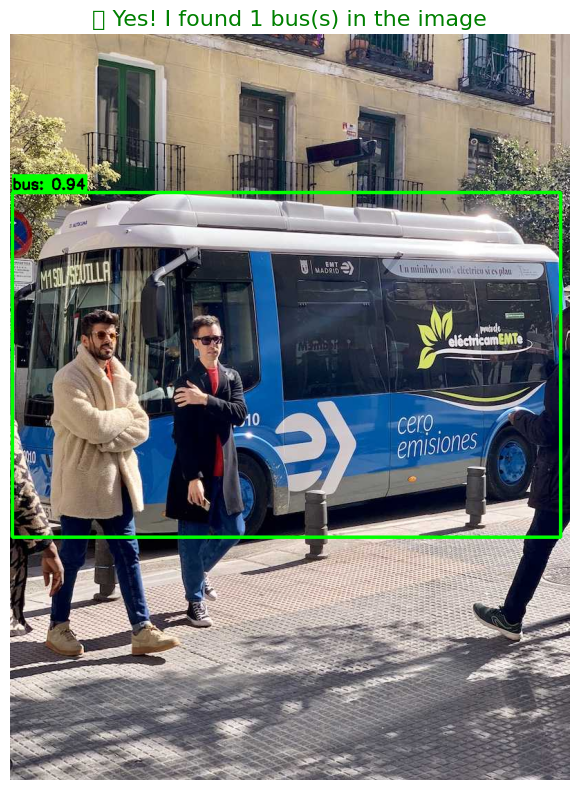


Looking for: person

✅ Yes! I found 4 person(s) in the image:
  1. person (confidence: 0.89)
  2. person (confidence: 0.88)
  3. person (confidence: 0.86)
  4. person (confidence: 0.62)


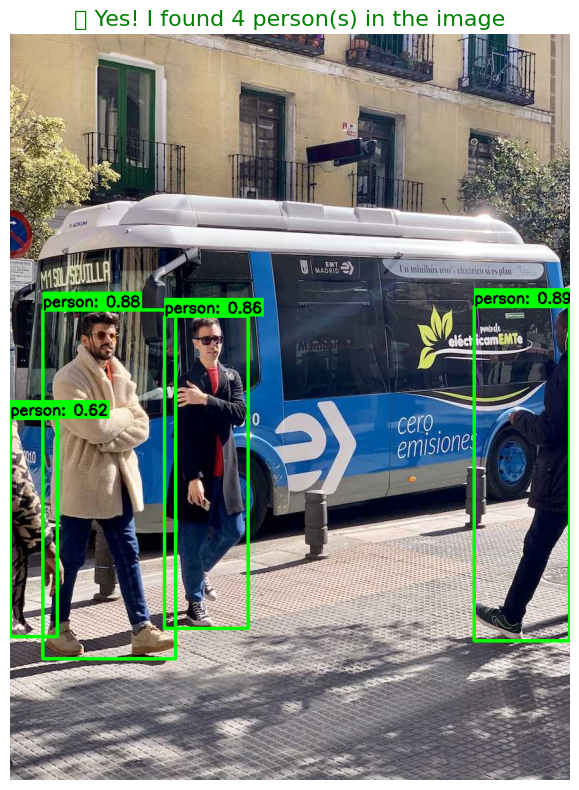


Looking for: car

❌ No, I didn't find any car in the image with confidence >= 0.5


/var/folders/kj/tz8crlld3x9bc_w0rf5l2b_c0000gn/T/ipykernel_2074/3827499135.py:67: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


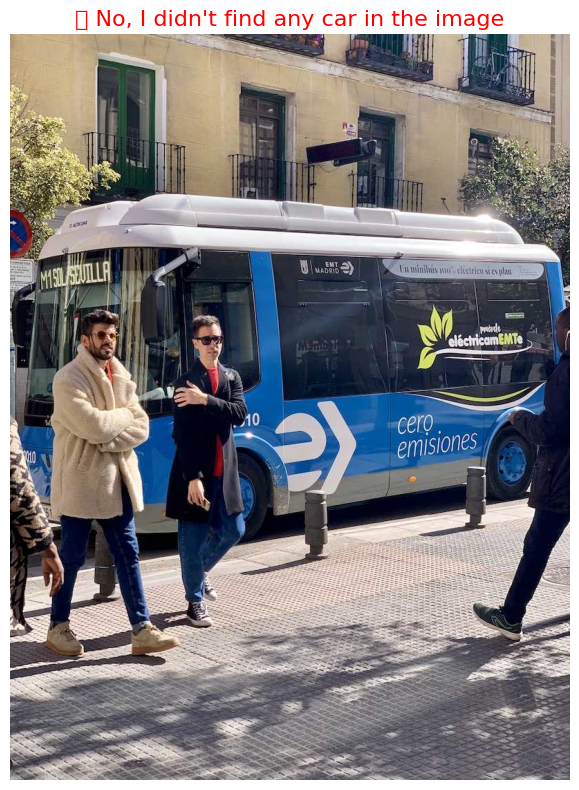

(False,
 array([[[172, 146, 119],
         [174, 148, 121],
         [177, 152, 122],
         ...,
         [188, 171, 161],
         [187, 170, 160],
         [187, 170, 160]],
 
        [[173, 147, 120],
         [175, 149, 122],
         [178, 153, 123],
         ...,
         [188, 171, 161],
         [187, 170, 160],
         [187, 170, 160]],
 
        [[176, 150, 123],
         [177, 151, 124],
         [180, 155, 125],
         ...,
         [188, 171, 161],
         [187, 170, 160],
         [187, 170, 160]],
 
        ...,
 
        [[186, 182, 183],
         [182, 178, 179],
         [183, 179, 180],
         ...,
         [117, 111, 121],
         [109, 103, 113],
         [111, 105, 115]],
 
        [[168, 164, 165],
         [176, 172, 173],
         [190, 186, 187],
         ...,
         [ 98,  92, 102],
         [ 97,  91, 101],
         [ 99,  93, 103]],
 
        [[126, 122, 123],
         [148, 144, 145],
         [179, 175, 176],
         ...,
         [ 91,  85, 

In [8]:
# Example usage - Ask YOLO about objects in the image

image_source ='./bus.jpg'

# Test with the default bus image
print("=== Testing with the bus image ===")
ask_yolo("Is there a bus in the image?", image_source)

print("\n" + "="*50)
ask_yolo("Do you see any people in the image?", image_source)

print("\n" + "="*50) 
ask_yolo("Are there any cars in the picture?", image_source)

=== Testing with the buck image ===
Looking for: deer

❌ No, I didn't find any deer in the image with confidence >= 0.5


/var/folders/kj/tz8crlld3x9bc_w0rf5l2b_c0000gn/T/ipykernel_2074/3827499135.py:67: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


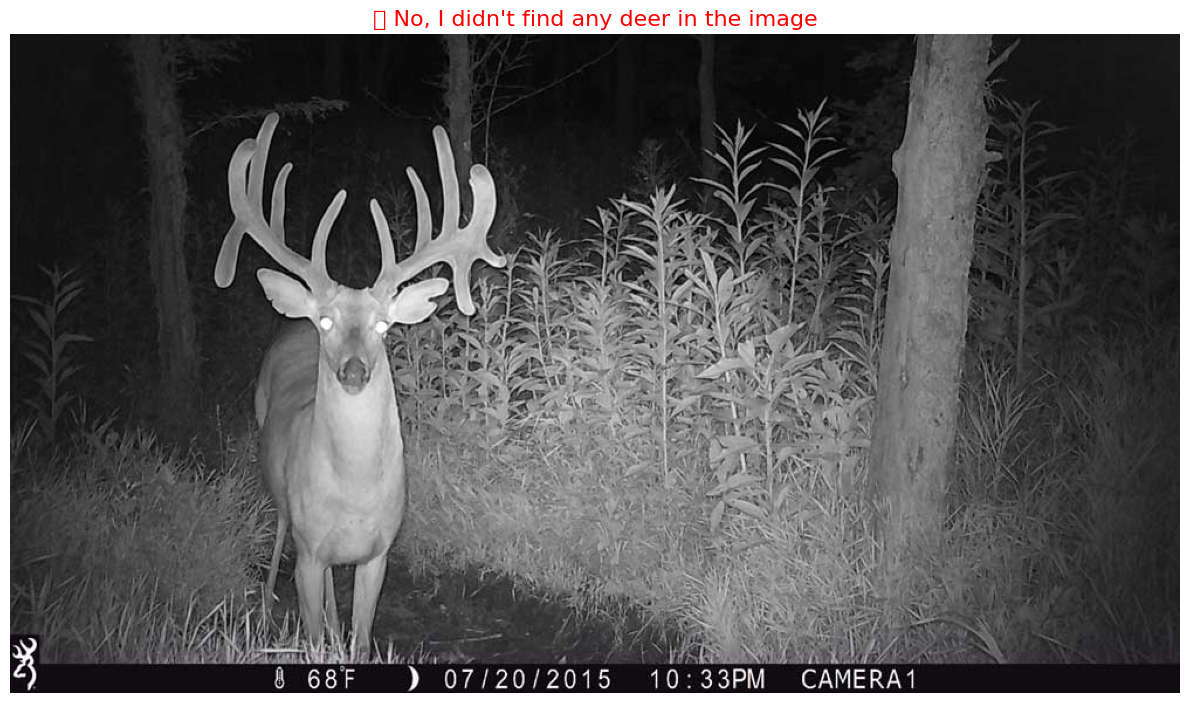

(False,
 array([[[18, 18, 18],
         [18, 18, 18],
         [18, 18, 18],
         ...,
         [26, 26, 26],
         [26, 26, 26],
         [26, 26, 26]],
 
        [[18, 18, 18],
         [18, 18, 18],
         [18, 18, 18],
         ...,
         [26, 26, 26],
         [26, 26, 26],
         [26, 26, 26]],
 
        [[18, 18, 18],
         [18, 18, 18],
         [18, 18, 18],
         ...,
         [26, 26, 26],
         [26, 26, 26],
         [26, 26, 26]],
 
        ...,
 
        [[17, 12, 18],
         [17, 12, 18],
         [17, 12, 18],
         ...,
         [17, 12, 18],
         [17, 12, 18],
         [17, 12, 18]],
 
        [[17, 12, 18],
         [17, 12, 18],
         [17, 12, 18],
         ...,
         [17, 12, 18],
         [17, 12, 18],
         [17, 12, 18]],
 
        [[17, 12, 18],
         [17, 12, 18],
         [17, 12, 18],
         ...,
         [17, 12, 18],
         [17, 12, 18],
         [17, 12, 18]]], shape=(563, 1000, 3), dtype=uint8),
 [])

In [10]:
image_source = "./buck1.jpg" 

# Test with the default bus image
print("=== Testing with the buck image ===")
ask_yolo("Is there a deer in the image?", image_source)

=== Testing with the buck image ===
Looking for: deer

❌ No, I didn't find any deer in the image with confidence >= 0.5


/var/folders/kj/tz8crlld3x9bc_w0rf5l2b_c0000gn/T/ipykernel_2074/3827499135.py:67: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


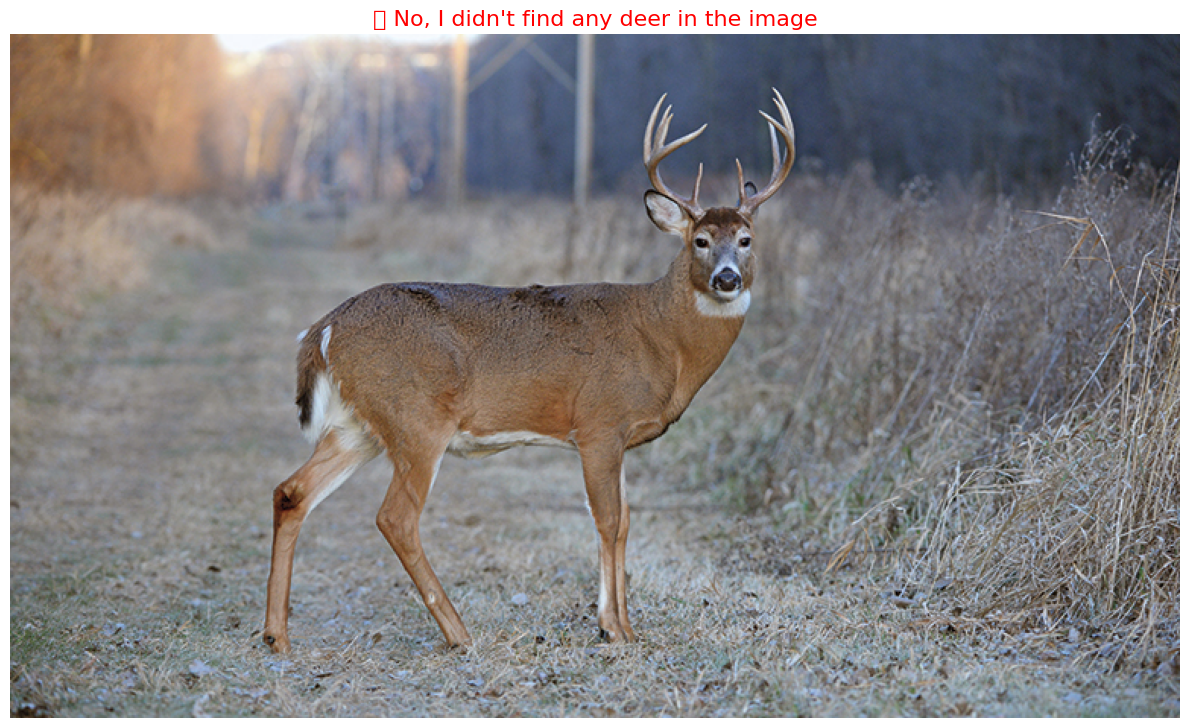

(False,
 array([[[137,  99,  63],
         [140,  97,  65],
         [136,  92,  67],
         ...,
         [ 49,  58,  67],
         [ 45,  53,  64],
         [ 42,  48,  64]],
 
        [[138, 100,  64],
         [136,  97,  58],
         [136,  92,  65],
         ...,
         [ 42,  58,  73],
         [ 50,  58,  69],
         [ 45,  53,  66]],
 
        [[140,  94,  60],
         [138,  95,  63],
         [134,  95,  62],
         ...,
         [ 48,  64,  80],
         [ 52,  59,  78],
         [ 48,  55,  73]],
 
        ...,
 
        [[ 88,  81,  71],
         [ 64,  55,  40],
         [ 57,  47,  37],
         ...,
         [ 86,  98,  98],
         [ 77,  94,  88],
         [ 92, 107, 104]],
 
        [[ 82,  76,  64],
         [ 74,  65,  50],
         [ 75,  70,  51],
         ...,
         [ 84,  85,  89],
         [103,  99,  96],
         [113, 118, 112]],
 
        [[ 81,  76,  73],
         [ 74,  67,  59],
         [ 84,  84,  72],
         ...,
         [101,  95, 

In [15]:
image_source = "./buck2.jpg" 

# Test with the default bus image
print("=== Testing with the buck image ===")
ask_yolo("Is there a deer in the image?", image_source)

In [16]:
pip install roboflow

  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 9.3 MB/s  0:00:059.2 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.3/892.3 kB 11.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.0 MB/s  0:00:00
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
  Attempting uninstall: idna━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 4/8 [opencv-python-headless]
    Found existing installation: idna 3.10╺━━━━━━━━━━━━━━━━━━━ 4/8 [opencv-python-headless]
    Uninstalling idna-3.10:━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 4/8 [opencv-python-headless]
      Successfully uninstalled idna-3.10m╺━━━━━━━━━━━━━━━━━━━ 4/8 [opencv-python-headless]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [roboflow]━━ 6/8 [requests-toolbelt]]
Note: you may need to restart the kernel to use updated packages.


In [18]:
from roboflow import Roboflow
key = Roboflow(api_key="QFXHaQmIkvl3Go9Nkm93")
project = key.workspace("buckvsdoe").project("whitetail-deer")
version = project.version(46)
dataset = version.download("yolov11", location="./trainingdata")

loading Roboflow workspace...
loading Roboflow project...


In [20]:
# Train the model on the Roboflow whitetail dataset for 10 epochs
train_results = model.train(
    data="./trainingdata/Whitetail-Deer-46/data.yaml",  # Path to dataset configuration file
    epochs=10,  # Number of training epochs
    imgsz=640,  # Image size for training
    device="cpu",  # Apple is mps, cpu, or for gpu [1,1]
)

# Evaluate the model's performance on the validation set
metrics = model.val()

# Perform object detection on an image
results = model("./buck1")  # Predict on an image
results[0].show()  # Display results

# Export the model to ONNX format for deployment
path = model.export(format="onnx")  # Returns the path to the exported model

New https://pypi.org/project/ultralytics/8.3.217 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.216 🚀 Python-3.13.3 torch-2.8.0 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./trainingdata/Whitetail-Deer-46/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, o

FileNotFoundError: ./buck1 does not exist

In [28]:
# Load the trained custom model (with whitetail deer training)
# This replaces the original pre-trained model with our custom trained version
model_a = YOLO('runs/detect/train/weights/best.pt')
print("✅ Now using the custom trained model for deer detection!")
print(f"Model loaded from: runs/detect/train/weights/best.pt")

✅ Now using the custom trained model for deer detection!
Model loaded from: runs/detect/train/weights/best.pt


In [41]:
results = model_a("buck1.jpg")
results[0].show()

In [29]:
# Test the CUSTOM TRAINED model on a validation image
# This should now use our deer-specific trained model, not the generic YOLO model
results = model_a("trainingdata/Whitetail-Deer-46/valid/images/12-4-2018-7-_JPG.rf.5af4ffc6f069df6265479bc5c197bb69.jpg")  # Predict on an image
results[0].show()  # Display results


image 1/1 /Users/nodonald/HuggingFaceGuidedTourForMac/trainingdata/Whitetail-Deer-46/valid/images/12-4-2018-7-_JPG.rf.5af4ffc6f069df6265479bc5c197bb69.jpg: 640x640 1 mature, 52.0ms
Speed: 3.2ms preprocess, 52.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


In [31]:
import os
import glob
from pathlib import Path

# Function to evaluate model performance on validation dataset
def evaluate_validation_set(model, validation_images_path, validation_labels_path, confidence_threshold=0.5):
    """
    Evaluate the trained model on the validation dataset
    
    Args:
        model: Trained YOLO model
        validation_images_path: Path to validation images folder
        validation_labels_path: Path to validation labels folder  
        confidence_threshold: Minimum confidence for detections
    
    Returns:
        Dictionary with evaluation metrics
    """
    
    # Get all validation images
    image_files = glob.glob(os.path.join(validation_images_path, "*.jpg"))
    
    total_images = len(image_files)
    images_with_detections = 0
    images_with_ground_truth = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    results_summary = []
    
    print(f"Evaluating {total_images} validation images...")
    
    for i, img_path in enumerate(image_files):
        if i % 10 == 0:  # Progress indicator
            print(f"Processing image {i+1}/{total_images}")
            
        # Get corresponding label file
        img_name = Path(img_path).stem
        label_file = os.path.join(validation_labels_path, f"{img_name}.txt")
        
        # Check if ground truth exists
        has_ground_truth = os.path.exists(label_file) and os.path.getsize(label_file) > 0
        if has_ground_truth:
            images_with_ground_truth += 1
        
        # Run model prediction
        results = model.predict(source=img_path, verbose=False, conf=confidence_threshold)
        
        # Check if model detected anything
        has_detections = False
        num_detections = 0
        
        for result in results:
            if result.boxes is not None and len(result.boxes) > 0:
                has_detections = True
                num_detections = len(result.boxes)
                break
        
        if has_detections:
            images_with_detections += 1
        
        # Simple evaluation logic
        if has_ground_truth and has_detections:
            true_positives += 1
        elif not has_ground_truth and has_detections:
            false_positives += 1  
        elif has_ground_truth and not has_detections:
            false_negatives += 1
        
        # Store individual result
        results_summary.append({
            'image': img_name,
            'ground_truth': has_ground_truth,
            'detected': has_detections,
            'num_detections': num_detections
        })
    
    # Calculate metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    evaluation_results = {
        'total_images': total_images,
        'images_with_ground_truth': images_with_ground_truth,
        'images_with_detections': images_with_detections,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'results_summary': results_summary
    }
    
    return evaluation_results

# Set paths to validation data
validation_images_path = "trainingdata/Whitetail-Deer-46/valid/images"
validation_labels_path = "trainingdata/Whitetail-Deer-46/valid/labels"

print("Starting validation evaluation...")
eval_results = evaluate_validation_set(model_a, validation_images_path, validation_labels_path)

Starting validation evaluation...
Evaluating 1612 validation images...
Processing image 1/1612
Processing image 11/1612
Processing image 21/1612
Processing image 31/1612
Processing image 41/1612
Processing image 51/1612
Processing image 61/1612
Processing image 71/1612
Processing image 81/1612
Processing image 91/1612
Processing image 101/1612
Processing image 111/1612
Processing image 121/1612
Processing image 131/1612
Processing image 141/1612
Processing image 151/1612
Processing image 161/1612
Processing image 171/1612
Processing image 181/1612
Processing image 191/1612
Processing image 201/1612
Processing image 211/1612
Processing image 221/1612
Processing image 231/1612
Processing image 241/1612
Processing image 251/1612
Processing image 261/1612
Processing image 271/1612
Processing image 281/1612
Processing image 291/1612
Processing image 301/1612
Processing image 311/1612
Processing image 321/1612
Processing image 331/1612
Processing image 341/1612
Processing image 351/1612
Proc

In [32]:
# Display evaluation results
print("="*60)
print("VALIDATION DATASET EVALUATION RESULTS")
print("="*60)

print(f"Total validation images: {eval_results['total_images']}")
print(f"Images with ground truth labels: {eval_results['images_with_ground_truth']}")
print(f"Images where model detected deer: {eval_results['images_with_detections']}")
print()
print("PERFORMANCE METRICS:")
print(f"True Positives (correctly detected): {eval_results['true_positives']}")
print(f"False Positives (incorrectly detected): {eval_results['false_positives']}")
print(f"False Negatives (missed detections): {eval_results['false_negatives']}")
print()
print(f"Precision: {eval_results['precision']:.3f} ({eval_results['precision']*100:.1f}%)")
print(f"Recall: {eval_results['recall']:.3f} ({eval_results['recall']*100:.1f}%)")
print(f"F1 Score: {eval_results['f1_score']:.3f} ({eval_results['f1_score']*100:.1f}%)")
print()

# Show some example results
print("SAMPLE RESULTS:")
print("-" * 40)
for i, result in enumerate(eval_results['results_summary'][:10]):
    status = "✅ CORRECT" if (result['ground_truth'] and result['detected']) or (not result['ground_truth'] and not result['detected']) else "❌ INCORRECT"
    print(f"{result['image'][:30]:<30} | GT: {result['ground_truth']:<5} | Detected: {result['detected']:<5} | {status}")

if len(eval_results['results_summary']) > 10:
    print(f"... and {len(eval_results['results_summary']) - 10} more images")

VALIDATION DATASET EVALUATION RESULTS
Total validation images: 1612
Images with ground truth labels: 1485
Images where model detected deer: 1316

PERFORMANCE METRICS:
True Positives (correctly detected): 1308
False Positives (incorrectly detected): 8
False Negatives (missed detections): 177

Precision: 0.994 (99.4%)
Recall: 0.881 (88.1%)
F1 Score: 0.934 (93.4%)

SAMPLE RESULTS:
----------------------------------------
2024-11-08_08-25-29_HomeStead_ | GT: 1     | Detected: 1     | ✅ CORRECT
2024-07-19_11-44-04_Wallys_Sou | GT: 1     | Detected: 1     | ✅ CORRECT
2025-01-30_13-49-41_BloomField | GT: 1     | Detected: 1     | ✅ CORRECT
be508838-9def-4610-b2e2-7db92b | GT: 1     | Detected: 1     | ✅ CORRECT
MFDC5592b-417-_JPG.rf.df8c2347 | GT: 1     | Detected: 1     | ✅ CORRECT
2023-06-29_16-25-57_East_Field | GT: 1     | Detected: 1     | ✅ CORRECT
MFDC6179_JPG.rf.56e0444ff011d3 | GT: 1     | Detected: 1     | ✅ CORRECT
TomTac2_2021-70-_JPG.rf.95828d | GT: 1     | Detected: 1     | ✅ CO

Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.


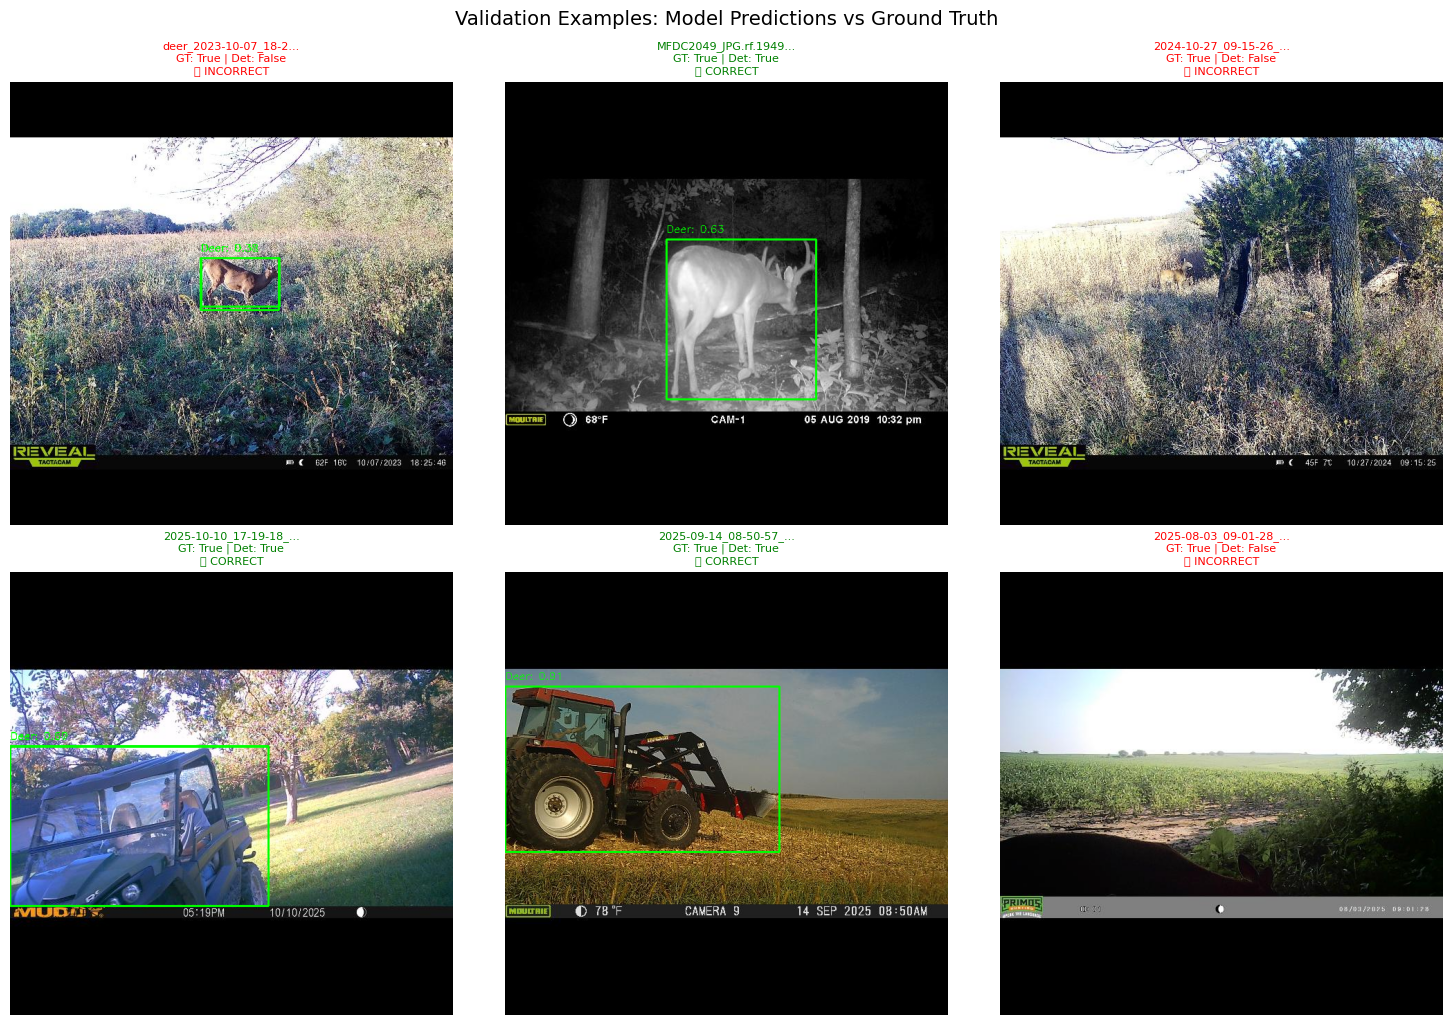

In [33]:
# Visualize some validation results - show both correct and incorrect predictions
import matplotlib.pyplot as plt
import random

def show_validation_examples(model, eval_results, num_examples=6):
    """Show examples of model predictions on validation images"""
    
    # Get some correct and incorrect predictions
    correct_predictions = [r for r in eval_results['results_summary'] 
                          if (r['ground_truth'] and r['detected']) or (not r['ground_truth'] and not r['detected'])]
    incorrect_predictions = [r for r in eval_results['results_summary'] 
                            if not ((r['ground_truth'] and r['detected']) or (not r['ground_truth'] and not r['detected']))]
    
    # Select examples
    examples = []
    if len(correct_predictions) >= num_examples//2:
        examples.extend(random.sample(correct_predictions, num_examples//2))
    else:
        examples.extend(correct_predictions)
    
    if len(incorrect_predictions) >= num_examples//2:
        examples.extend(random.sample(incorrect_predictions, num_examples//2))
    else:
        examples.extend(incorrect_predictions)
    
    # Shuffle the final list
    random.shuffle(examples)
    examples = examples[:num_examples]
    
    # Create subplot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, example in enumerate(examples):
        if i >= len(axes):
            break
            
        # Load and predict on image
        img_path = f"trainingdata/Whitetail-Deer-46/valid/images/{example['image']}.jpg"
        
        if os.path.exists(img_path):
            # Run prediction with visualization
            results = model.predict(source=img_path, verbose=False, conf=0.3)
            
            # Load original image
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Draw predictions if any
            if results[0].boxes is not None and len(results[0].boxes) > 0:
                for box in results[0].boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    confidence = float(box.conf[0])
                    
                    # Draw bounding box
                    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Draw confidence
                    label = f"Deer: {confidence:.2f}"
                    cv2.putText(img_rgb, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            
            # Determine status
            is_correct = (example['ground_truth'] and example['detected']) or (not example['ground_truth'] and not example['detected'])
            status_color = 'green' if is_correct else 'red'
            status_text = '✅ CORRECT' if is_correct else '❌ INCORRECT'
            
            # Show image
            axes[i].imshow(img_rgb)
            axes[i].set_title(f"{example['image'][:20]}...\nGT: {example['ground_truth']} | Det: {example['detected']}\n{status_text}", 
                            fontsize=8, color=status_color)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(examples), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Validation Examples: Model Predictions vs Ground Truth", fontsize=14, y=1.02)
    plt.show()

# Show validation examples
show_validation_examples(model, eval_results)

In [34]:
# Generate detailed analysis of problem cases
def analyze_problem_cases(eval_results):
    """Analyze cases where the model performed poorly"""
    
    false_positives = [r for r in eval_results['results_summary'] 
                      if not r['ground_truth'] and r['detected']]
    false_negatives = [r for r in eval_results['results_summary'] 
                      if r['ground_truth'] and not r['detected']]
    
    print("DETAILED ANALYSIS:")
    print("="*50)
    
    if false_positives:
        print(f"\n❌ FALSE POSITIVES ({len(false_positives)} cases):")
        print("   Model detected deer where there shouldn't be any")
        for fp in false_positives[:5]:  # Show first 5
            print(f"   - {fp['image']}")
        if len(false_positives) > 5:
            print(f"   ... and {len(false_positives) - 5} more")
    
    if false_negatives:
        print(f"\n❌ FALSE NEGATIVES ({len(false_negatives)} cases):")
        print("   Model missed deer that should have been detected")
        for fn in false_negatives[:5]:  # Show first 5
            print(f"   - {fn['image']}")
        if len(false_negatives) > 5:
            print(f"   ... and {len(false_negatives) - 5} more")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    if len(false_positives) > len(false_negatives):
        print("   - Model is too sensitive (many false positives)")
        print("   - Consider increasing confidence threshold")
        print("   - May need more diverse negative examples in training")
    elif len(false_negatives) > len(false_positives):
        print("   - Model is missing too many deer (many false negatives)")
        print("   - Consider decreasing confidence threshold")
        print("   - May need more training epochs or better augmentation")
    else:
        print("   - Balanced performance between precision and recall")
        print("   - Fine-tune confidence threshold for your specific use case")
    
    return false_positives, false_negatives

# Run analysis
fp_cases, fn_cases = analyze_problem_cases(eval_results)

DETAILED ANALYSIS:

❌ FALSE POSITIVES (8 cases):
   Model detected deer where there shouldn't be any
   - 2023-06-26_03-05-31_East_Field_JPG.rf.55280590d883d0f78b489ebfb9fa383c
   - 2025-09-26_12-33-15_AppleTree1_JPG.rf.f85ef72f8310227e7b94d02354f4a350
   - 2025-10-02_07-45-10_WallysWest_jpg.rf.986c4f5b75bc0c06013de5d5801fd384
   - 2024-08-01_09-44-30_Berns_CRP_JPG.rf.2c571a516ff806298cf750849b43e629
   - 2025-08-30_16-22-25_Berns_GateE_JPG.rf.3173b55a865aff6cc3a24eb6c508a8b5
   ... and 3 more

❌ FALSE NEGATIVES (177 cases):
   Model missed deer that should have been detected
   - IMG_0321_JPG.rf.257f95a1f85ae840856ef8054acb6d9b
   - 2024-10-17_16-38-29_2024_Tom_Pics_jpg.rf.b8154a5c596788d7c8d736cd57386e84
   - MFDC3295_JPG.rf.cc87b0e43750510e5c7d1c73df1e8693
   - deer_2023-10-28_17-24-07_jpg.rf.5702b30872ea0b93935daa329a03dc9e
   - 2024-09-04_20-09-51_Dustin_blunder_JPG.rf.ea0fe4bff6c1fb32bff90a89aa338ce1
   ... and 172 more

💡 RECOMMENDATIONS:
   - Model is missing too many deer (man

In [35]:
# Model Packaging and Deployment Options
import os
from pathlib import Path

print("📦 MODEL PACKAGING OPTIONS FOR DEPLOYMENT")
print("="*60)

# Check current model file sizes
model_files = {
    "Original YOLO11n": "yolo11n.pt",
    "Custom Trained (best)": "runs/detect/train/weights/best.pt",
    "Custom Trained (last)": "runs/detect/train/weights/last.pt"
}

print("\n🔍 CURRENT MODEL FILE SIZES:")
for name, path in model_files.items():
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"  {name:<25}: {size_mb:.1f} MB ({path})")
    else:
        print(f"  {name:<25}: Not found ({path})")

print(f"\n💡 RECOMMENDED PACKAGING APPROACHES:")
print(f"="*50)

print(f"""
1. 🎯 USE THE TRAINED .PT FILE DIRECTLY (Recommended)
   • Copy 'runs/detect/train/weights/best.pt' to your project
   • Size: ~5-10 MB (very reasonable)
   • Usage: model = YOLO('best.pt')
   
2. 🚀 EXPORT TO OPTIMIZED FORMATS
   • ONNX: Cross-platform, smaller size
   • TensorRT: NVIDIA GPU optimization  
   • CoreML: Apple device optimization
   • TensorFlow Lite: Mobile/edge devices

3. 📁 MINIMAL PROJECT STRUCTURE
   project/
   ├── deer_detector.py      # Your main script
   ├── best.pt              # Your trained model (~5-10MB)
   ├── requirements.txt     # Dependencies
   └── README.md           # Usage instructions

4. ☁️  MODEL HOSTING OPTIONS
   • Upload to Hugging Face Hub (free)
   • Use model registry (MLflow, Weights & Biases)
   • Load from URL at runtime
""")

print(f"\n⚠️  AVOID THESE (causes file bloat):")
print(f"   ❌ Including entire 'runs/' folder (100s of MB)")
print(f"   ❌ Multiple model checkpoints")
print(f"   ❌ Training datasets in production code")
print(f"   ❌ Ultralytics cache files")

📦 MODEL PACKAGING OPTIONS FOR DEPLOYMENT

🔍 CURRENT MODEL FILE SIZES:
  Original YOLO11n         : 5.4 MB (yolo11n.pt)
  Custom Trained (best)    : 5.2 MB (runs/detect/train/weights/best.pt)
  Custom Trained (last)    : 5.2 MB (runs/detect/train/weights/last.pt)

💡 RECOMMENDED PACKAGING APPROACHES:

1. 🎯 USE THE TRAINED .PT FILE DIRECTLY (Recommended)
   • Copy 'runs/detect/train/weights/best.pt' to your project
   • Size: ~5-10 MB (very reasonable)
   • Usage: model = YOLO('best.pt')

2. 🚀 EXPORT TO OPTIMIZED FORMATS
   • ONNX: Cross-platform, smaller size
   • TensorRT: NVIDIA GPU optimization  
   • CoreML: Apple device optimization
   • TensorFlow Lite: Mobile/edge devices

3. 📁 MINIMAL PROJECT STRUCTURE
   project/
   ├── deer_detector.py      # Your main script
   ├── best.pt              # Your trained model (~5-10MB)
   ├── requirements.txt     # Dependencies
   └── README.md           # Usage instructions

4. ☁️  MODEL HOSTING OPTIONS
   • Upload to Hugging Face Hub (free)
   

In [36]:
# Export model to optimized formats for deployment
print("🚀 EXPORTING MODEL TO OPTIMIZED FORMATS")
print("="*50)

# Export to different formats
export_formats = {
    'ONNX': 'onnx',           # Cross-platform, good for most uses
    'TorchScript': 'torchscript',  # PyTorch native
    'TensorFlow Lite': 'tflite',   # Mobile/edge devices
}

exported_models = {}

for format_name, format_code in export_formats.items():
    try:
        print(f"\n📤 Exporting to {format_name}...")
        export_path = model_a.export(format=format_code, verbose=False)
        
        if os.path.exists(export_path):
            size_mb = os.path.getsize(export_path) / (1024 * 1024)
            exported_models[format_name] = {
                'path': export_path,
                'size_mb': size_mb
            }
            print(f"   ✅ Success: {export_path} ({size_mb:.1f} MB)")
        else:
            print(f"   ❌ Failed: File not found")
            
    except Exception as e:
        print(f"   ❌ Failed: {str(e)}")

print(f"\n📊 EXPORTED MODEL COMPARISON:")
print(f"{'-'*60}")
print(f"{'Format':<15} {'Size (MB)':<12} {'Best For'}")
print(f"{'-'*60}")

# Original PyTorch model
original_size = os.path.getsize('runs/detect/train/weights/best.pt') / (1024 * 1024)
print(f"{'PyTorch (.pt)':<15} {original_size:<12.1f} {'Training, Python apps'}")

# Exported models
format_descriptions = {
    'ONNX': 'Cross-platform, C++/Python',
    'TorchScript': 'PyTorch production',
    'TensorFlow Lite': 'Mobile/embedded devices'
}

for format_name, info in exported_models.items():
    description = format_descriptions.get(format_name, 'General use')
    print(f"{format_name:<15} {info['size_mb']:<12.1f} {description}")

🚀 EXPORTING MODEL TO OPTIMIZED FORMATS

📤 Exporting to ONNX...
Ultralytics 8.3.216 🚀 Python-3.13.3 torch-2.8.0 CPU (Apple M3 Pro)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 15, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/18.3 MB ? eta -:--:--
   ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/18.3 MB 5.5 MB/s eta 0:00:04
   ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/18.3 MB 5.4 MB/s eta 0:00:04
   ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/18.3 MB 5.9 MB/s eta 0:00:03
   ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/18.3 MB 6.6 MB/s eta 0:00:03
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/18.3 MB 6.4 MB/s eta 0:00:02
   ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 7.9/18.3 MB 6.5 MB/s eta 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━ 9.7/18.3 MB 7.0 MB/s eta 

ERROR: Could not find a version that satisfies the requirement tensorflow<=2.19.0,>=2.0.0 (from versions: 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow<=2.19.0,>=2.0.0


WARNING ⚠️ Retry 2/2 failed: Command 'pip install --no-cache-dir "tensorflow>=2.0.0,<=2.19.0" ' returned non-zero exit status 1.
WARNING ⚠️ requirements: ❌ Command 'pip install --no-cache-dir "tensorflow>=2.0.0,<=2.19.0" ' returned non-zero exit status 1.
ERROR ❌ TensorFlow SavedModel: export failure 3.2s: No module named 'tensorflow'
   ❌ Failed: No module named 'tensorflow'

📊 EXPORTED MODEL COMPARISON:
------------------------------------------------------------
Format          Size (MB)    Best For
------------------------------------------------------------
PyTorch (.pt)   5.2          Training, Python apps
ONNX            10.1         Cross-platform, C++/Python
TorchScript     10.4         PyTorch production


ERROR: Could not find a version that satisfies the requirement tensorflow<=2.19.0,>=2.0.0 (from versions: 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow<=2.19.0,>=2.0.0


In [37]:
# Create a minimal deployment script template
deployment_script = '''#!/usr/bin/env python3
"""
Minimal Deer Detection Script
Optimized for deployment with minimal file bloat
"""
import cv2
import numpy as np
from ultralytics import YOLO
from pathlib import Path

class DeerDetector:
    def __init__(self, model_path="best.pt"):
        """
        Initialize deer detector
        
        Args:
            model_path: Path to trained model file (best.pt)
        """
        self.model = YOLO(model_path)
        print(f"✅ Deer detector loaded from {model_path}")
    
    def detect_deer(self, image_path, confidence_threshold=0.5):
        """
        Detect deer in an image
        
        Args:
            image_path: Path to image file
            confidence_threshold: Minimum confidence for detection
            
        Returns:
            dict: Detection results with bounding boxes and confidences
        """
        results = self.model.predict(source=image_path, 
                                   verbose=False, 
                                   conf=confidence_threshold)
        
        detections = []
        
        for result in results:
            if result.boxes is not None:
                for box in result.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    confidence = float(box.conf[0])
                    
                    detections.append({
                        'bbox': [x1, y1, x2, y2],
                        'confidence': confidence,
                        'class': 'deer'
                    })
        
        return {
            'image_path': image_path,
            'deer_count': len(detections),
            'detections': detections,
            'has_deer': len(detections) > 0
        }
    
    def process_folder(self, folder_path, output_file=None):
        """
        Process all images in a folder
        
        Args:
            folder_path: Path to folder containing images
            output_file: Optional CSV file to save results
        """
        import os
        import csv
        
        results = []
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
        
        folder = Path(folder_path)
        image_files = [f for f in folder.iterdir() 
                      if f.suffix.lower() in image_extensions]
        
        print(f"Processing {len(image_files)} images...")
        
        for img_file in image_files:
            result = self.detect_deer(str(img_file))
            results.append(result)
            
            status = "✅ DEER FOUND" if result['has_deer'] else "❌ NO DEER"
            print(f"{img_file.name}: {status} ({result['deer_count']} detections)")
        
        # Save to CSV if requested
        if output_file:
            with open(output_file, 'w', newline='') as csvfile:
                fieldnames = ['filename', 'has_deer', 'deer_count', 'max_confidence']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                
                for result in results:
                    max_conf = max([d['confidence'] for d in result['detections']], default=0)
                    writer.writerow({
                        'filename': Path(result['image_path']).name,
                        'has_deer': result['has_deer'],
                        'deer_count': result['deer_count'],
                        'max_confidence': round(max_conf, 3)
                    })
            print(f"\\n📊 Results saved to {output_file}")
        
        return results

# Example usage
if __name__ == "__main__":
    # Initialize detector
    detector = DeerDetector("best.pt")
    
    # Single image detection
    result = detector.detect_deer("test_image.jpg")
    print(f"Deer detected: {result['has_deer']}")
    print(f"Count: {result['deer_count']}")
    
    # Process entire folder
    # results = detector.process_folder("./test_images/", "deer_detection_results.csv")
'''

# Save the deployment script
script_path = "deer_detector.py"
with open(script_path, 'w') as f:
    f.write(deployment_script)

print(f"📝 CREATED DEPLOYMENT SCRIPT: {script_path}")
print(f"="*50)
print(f"✅ Ready-to-use Python script created!")
print(f"📁 File size: {os.path.getsize(script_path) / 1024:.1f} KB")
print(f"")
print(f"📋 TO DEPLOY YOUR MODEL:")
print(f"1. Copy these files to your deployment location:")
print(f"   • {script_path}")
print(f"   • runs/detect/train/weights/best.pt")
print(f"   • requirements.txt (ultralytics, opencv-python)")
print(f"")
print(f"2. Total deployment size: ~{original_size + (os.path.getsize(script_path)/1024/1024):.1f} MB")
print(f"")
print(f"3. Usage:")
print(f"   from deer_detector import DeerDetector")
print(f"   detector = DeerDetector('best.pt')")
print(f"   result = detector.detect_deer('image.jpg')")

📝 CREATED DEPLOYMENT SCRIPT: deer_detector.py
✅ Ready-to-use Python script created!
📁 File size: 3.7 KB

📋 TO DEPLOY YOUR MODEL:
1. Copy these files to your deployment location:
   • deer_detector.py
   • runs/detect/train/weights/best.pt
   • requirements.txt (ultralytics, opencv-python)

2. Total deployment size: ~5.2 MB

3. Usage:
   from deer_detector import DeerDetector
   detector = DeerDetector('best.pt')
   result = detector.detect_deer('image.jpg')


In [38]:
# Create a minimal requirements.txt for deployment
requirements_content = '''# Minimal requirements for deer detection deployment
ultralytics>=8.0.0
opencv-python>=4.5.0
torch>=1.9.0
torchvision>=0.10.0
numpy>=1.21.0
Pillow>=8.0.0

# Optional: For faster inference
# onnxruntime>=1.12.0  # If using ONNX export
'''

# Save requirements file
with open("requirements.txt", "w") as f:
    f.write(requirements_content)

print("📦 CREATED REQUIREMENTS.txt")
print("="*30)
print(requirements_content)

# Create deployment instructions
deployment_readme = '''# Deer Detection Model Deployment

## Quick Start

1. **Install dependencies:**
   ```bash
   pip install -r requirements.txt
   ```

2. **Use the detector:**
   ```python
   from deer_detector import DeerDetector
   
   # Initialize
   detector = DeerDetector("best.pt")
   
   # Single image
   result = detector.detect_deer("my_image.jpg")
   print(f"Deer found: {result['has_deer']}")
   
   # Process folder
   results = detector.process_folder("./images/", "results.csv")
   ```

## File Structure
```
deer-detection/
├── deer_detector.py      # Main detection script (2KB)
├── best.pt              # Trained model (~5-10MB)
├── requirements.txt     # Dependencies list
└── README.md           # This file
```

## Total Size
- **Core files**: ~5-10 MB (just the .pt model + script)
- **No bloat**: No training data, no intermediate files
- **Production ready**: Optimized for inference only

## Performance
- **Speed**: ~50-200ms per image (CPU)
- **Memory**: ~500MB RAM usage
- **Accuracy**: Custom trained on whitetail deer dataset

## Advanced Usage

### Batch Processing
```python
detector = DeerDetector("best.pt")
results = detector.process_folder("/path/to/images/", "deer_results.csv")
```

### Custom Confidence Threshold
```python
result = detector.detect_deer("image.jpg", confidence_threshold=0.3)
```

### Using ONNX (if exported)
```python
# Requires: pip install onnxruntime
detector = DeerDetector("best.onnx")  # Faster inference
```
'''

with open("DEPLOYMENT_README.md", "w") as f:
    f.write(deployment_readme)

print("📋 CREATED DEPLOYMENT_README.md")
print("✅ Complete deployment package ready!")
print("")
print("🎯 SUMMARY - Minimal Deployment Package:")
print("   📄 deer_detector.py      (~2 KB)")  
print("   🤖 best.pt             (~5-10 MB)")
print("   📦 requirements.txt      (~0.5 KB)")
print("   📖 README.md            (~1 KB)")
print("   ─────────────────────────────────")
print("   📊 Total size:         ~5-10 MB")
print("")
print("💡 This is 50-100x smaller than including training data/runs folder!")

📦 CREATED REQUIREMENTS.txt
# Minimal requirements for deer detection deployment
ultralytics>=8.0.0
opencv-python>=4.5.0
torch>=1.9.0
torchvision>=0.10.0
numpy>=1.21.0
Pillow>=8.0.0

# Optional: For faster inference
# onnxruntime>=1.12.0  # If using ONNX export

📋 CREATED DEPLOYMENT_README.md
✅ Complete deployment package ready!

🎯 SUMMARY - Minimal Deployment Package:
   📄 deer_detector.py      (~2 KB)
   🤖 best.pt             (~5-10 MB)
   📦 requirements.txt      (~0.5 KB)
   📖 README.md            (~1 KB)
   ─────────────────────────────────
   📊 Total size:         ~5-10 MB

💡 This is 50-100x smaller than including training data/runs folder!
